In [1]:
import pandas as pd
import numpy as np
import os
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.options.display.max_colwidth = 100

In [2]:
df_train = pd.read_csv("Data/train.csv")[["text", "target"]]
df_test = pd.read_csv("Data/test.csv")

In [3]:
df_train

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...
7608,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part ...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffer...,1


In [4]:
df_train.describe()

,target
count,7613.00000
mean,0.42966
std,0.49506
min,0.00000
25%,0.00000
50%,0.00000
75%,1.00000
max,1.00000


In [5]:
y_train = df_train['target'].unique()
y_train

array([1, 0])

# EDA

In [6]:
# Filter the dataframe so that it does not crash the browser
train_filtered = df_train

# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.violin(train_filtered, x='target', points='outliers')
fig.update_layout( title='target  violin', 
                   xaxis = dict( showgrid=True, 
                                 rangeslider = dict( visible=True, thickness=0.05 )
                                ), 
                   yaxis = dict( showgrid=True), 
                   legend = dict( orientation='v' ),
                   paper_bgcolor='#FFFFFF')
fig.show(renderer="iframe")

In [7]:
# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.histogram(df_train, x='target', color='target', nbins=10, histnorm='density', histfunc='count')
fig.update_layout( title='label histogram', 
                   xaxis = dict( showgrid=True, 
                                 rangeslider = dict( visible=True, thickness=0.05 )
                                ), 
                   yaxis = dict( showgrid=True), 
                   legend = dict( orientation='v' ),
                   paper_bgcolor='#FFFFFF')

fig.show(renderer="iframe")

In [8]:
df_train['char_count'] = df_train['text'].apply(lambda x:len(x))
df_train['token_count'] = (df_train[['text']].apply(lambda x :(list(x.str.split(' '))))).apply(lambda x : x.str.len())

In [9]:
train_filtered = df_train
# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.density_contour(train_filtered, x='target', y='char_count')
fig.update_layout( title='label, char_count density contour', 
                   xaxis = dict( showgrid=True, 
                                 rangeslider = dict( visible=True, thickness=0.05 )
                                ), 
                   yaxis = dict( showgrid=True), 
                   legend = dict( orientation='v' ),
                   paper_bgcolor='#FFFFFF')
fig.show(renderer="iframe")

<AxesSubplot: xlabel='text', ylabel='Density'>

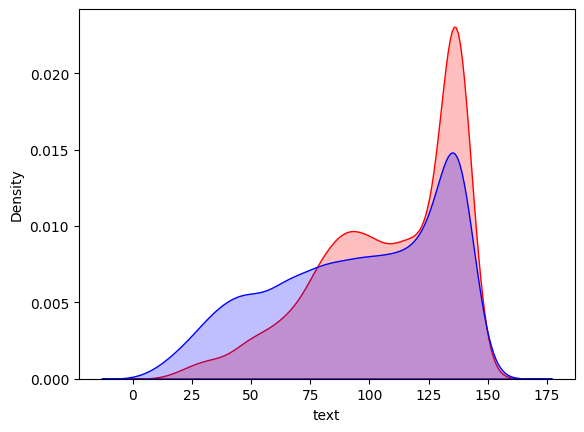

In [10]:
sns.kdeplot(df_train[df_train['target'] == 1]['text'].str.len(), fill=True, color='red')
sns.kdeplot(df_train[df_train['target'] == 0]['text'].str.len(), fill=True, color= 'blue')

In [11]:
fig = px.density_heatmap(df_train, x='target', y='char_count')
fig.update_layout( title='label, char_count density heatmap', 
                   xaxis = dict( showgrid=True, 
                                 rangeslider = dict( visible=True, thickness=0.05 )
                                ), 
                   yaxis = dict( showgrid=True), 
                   legend = dict( orientation='v' ),
                   paper_bgcolor='#FFFFFF')
fig.show(renderer="iframe")

In [12]:
fig = px.bar(df_train, x='target', y='token_count', color='target')
fig.update_layout( title='target, token_count bar chart', 
                   xaxis = dict( showgrid=True, 
                                 rangeslider = dict( visible=True, thickness=0.05 )
                                ), 
                   yaxis = dict( showgrid=True), 
                   legend = dict( orientation='v' ),
                   barmode='overlay', 
                   paper_bgcolor='#FFFFFF')
fig.show(renderer="iframe")

# Preprocessing

In [13]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

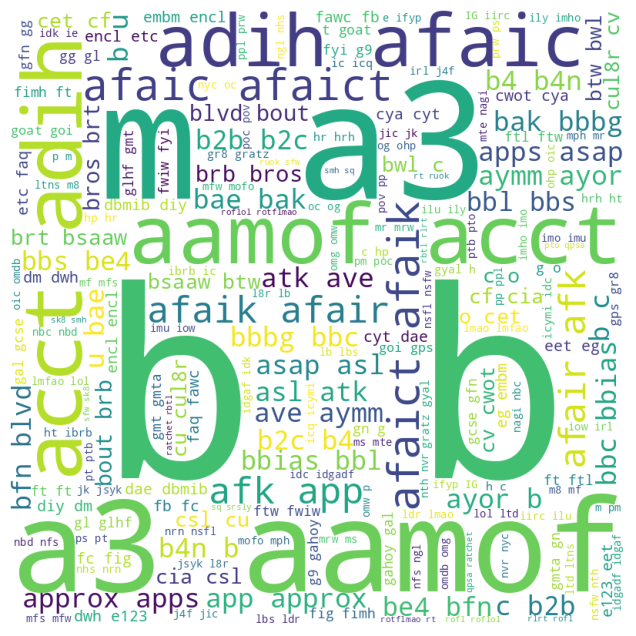

In [14]:
token = list(abbreviations.keys())
comment_words = ''
stopWords = set(STOPWORDS)


for i in range(len(token)):
    token[i] = token[i].lower()
      
    comment_words += " ".join(token)+" "
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopWords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
  
plt.show()

# Cleaning

In [15]:
space = re.compile('[/(){}\[\]\|@,;]')
symbols= re.compile('[^0-9a-z #+_]')

In [16]:
def work_abbr(word):
    if word.lower() in abbreviations.keys():
        return abbreviations[word.lower()]
    else: 
        return word

In [17]:
def sentence_clean(sentence):
    
    sentence = sentence.lower()
    #replace unwanted symbols
    sentence = space.sub(' ', sentence)
    sentence = symbols.sub('', sentence) 
    sentence = sentence.replace('x', '')
        
    #clean the senteces from abbreviations and filling words
    clean_sentence = " "
    for word in sentence.split():
        clean_word = work_abbr(word)
        
        if clean_word not in STOPWORDS:
            clean_sentence += clean_word + " "
        
    return clean_sentence

In [18]:
df_train['clean_text'] = df_train['text'].apply(sentence_clean)

In [19]:
df_train

,text,target,char_count,token_count,clean_text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,13,deeds reason #earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,1,38,7,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1,133,22,residents asked shelter place notified officers evacuation shelter place orders epected
3,"13,000 people receive #wildfires evacuation orders in California",1,65,9,13 000 people receive #wildfires evacuation orders california
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,17,got sent photo ruby #alaska smoke #wildfires pours school
...,...,...,...,...,...
7608,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,83,11,two giant cranes holding bridge collapse nearby homes tco stfmbbzfb5
7609,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part ...,1,125,20,aria_ahrary thetawniest control wild fires california even northern part state troubling
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,65,8,m194 0104 coordinated universal time 5km s volcano hawaii tco zdtoyd8ebj
7611,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffer...,1,137,19,police investigating ebike collided car little portugal ebike rider suffered serious nonlife th...


# Model

In [31]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

2023-01-02 18:22:31.272576: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-02 18:22:31.279149: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 18:22:31.285768: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-02 18:23:19.240878: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-02 18:23:20.633210: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1800000000 Hz


In [64]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer().fit(list(set(df_train['target'].tolist())))
sentences = df_train["clean_text"].tolist()

In [67]:
embed_matrix = []
for sent in sentences:
    embed_matrix.append(np.array(embed([sent])[0]).tolist())

In [68]:
X, Y = np.array(embed_matrix), lb.transform(df_train['target'].tolist())

In [69]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.15, shuffle=True, random_state=48)

In [76]:
#create the model
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=512))
model.add(tf.keras.layers.Dense(units=256, activation='relu',  kernel_regularizer='l2'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=128, activation='relu',  kernel_regularizer='l2'))
model.add(tf.keras.layers.Dropout(rate = .5))
model.add(tf.keras.layers.Dense(units=64, activation='relu',  kernel_regularizer='l2'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=32, activation='relu',  kernel_regularizer='l2'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

#add metrics calculations
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics =['accuracy']) 
#callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [77]:
model.fit(train_x , train_y, epochs=50, batch_size=10, validation_split=0.3, shuffle=False, callbacks=[callback])

Epoch 1/50
453/453 [==============================] - 44s 90ms/step - loss: 5.7086 - accuracy: 0.5888 - val_loss: 2.8426 - val_accuracy: 0.7477
Epoch 2/50
453/453 [==============================] - 22s 49ms/step - loss: 2.3305 - accuracy: 0.7627 - val_loss: 1.2752 - val_accuracy: 0.7992
Epoch 3/50
453/453 [==============================] - 23s 50ms/step - loss: 1.1773 - accuracy: 0.7749 - val_loss: 0.8063 - val_accuracy: 0.7951
Epoch 4/50
453/453 [==============================] - 17s 36ms/step - loss: 0.8189 - accuracy: 0.7764 - val_loss: 0.6684 - val_accuracy: 0.7997
Epoch 5/50
453/453 [==============================] - 13s 28ms/step - loss: 0.7010 - accuracy: 0.7811 - val_loss: 0.6237 - val_accuracy: 0.7961
Epoch 6/50
453/453 [==============================] - 10s 22ms/step - loss: 0.6657 - accuracy: 0.7783 - val_loss: 0.6001 - val_accuracy: 0.7945
Epoch 7/50
453/453 [==============================] - 17s 38ms/step - loss: 0.6507 - accuracy: 0.7778 - val_loss: 0.6079 - val_accuracy:

## Model visualization

In [79]:
import visualkeras

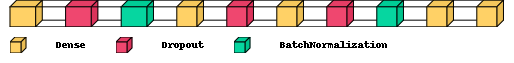

In [80]:
visualkeras.layered_view(model ,legend=True, draw_volume=True, spacing=30)

In [85]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

AttributeError: module 'tensorflow.compat.v2.__internal__' has no attribute 'dispatch'

## Result and Evaluation

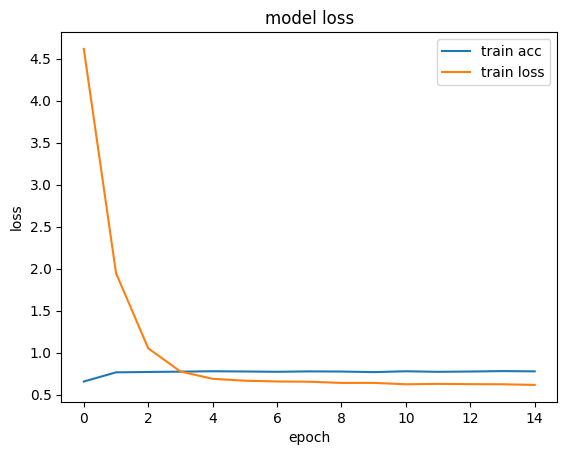

In [87]:
history = model.history
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train acc', 'train loss'], loc='upper right')
plt.show()

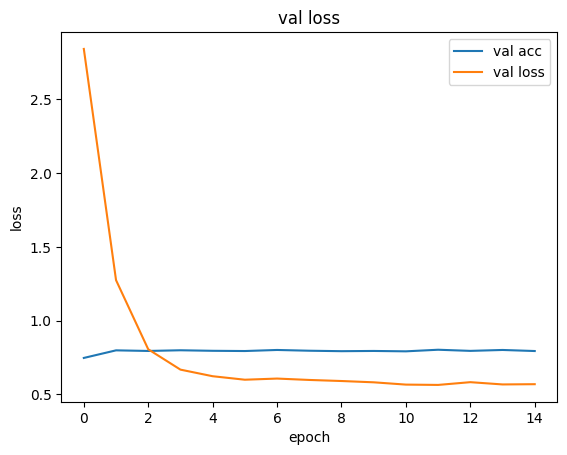

In [88]:
history = model.history
# summarize history for accuracy
plt.plot(history.history['val_accuracy'])
plt.title('val accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.title('val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val acc', 'val loss'], loc='upper right')
plt.show()

## Predicting on the validation dataset 

In [104]:
pred = model.predict(test_x)
pred  = pred >.75

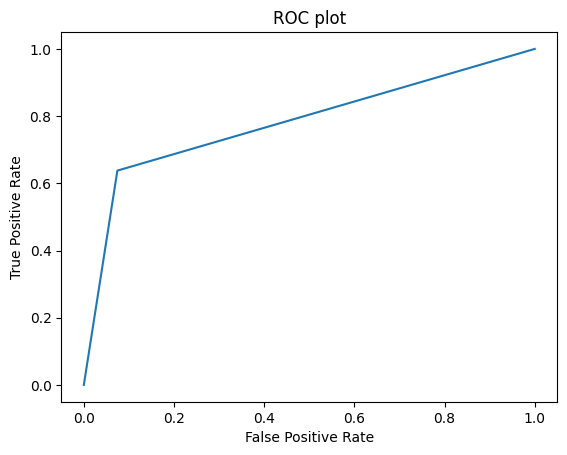

In [105]:
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
fpr, tpr, _ = roc_curve(test_y, pred , pos_label=1)
plt.plot(fpr,tpr)
plt.title("ROC plot")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Confusion Matrix

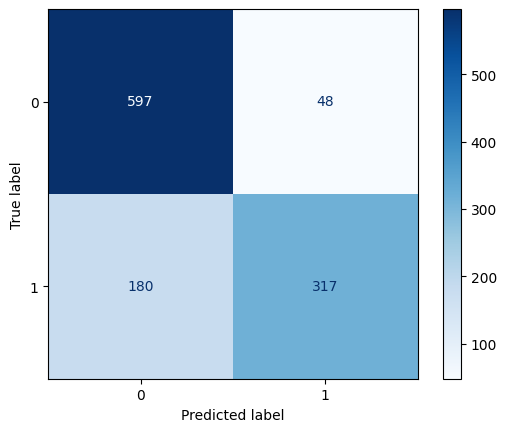

In [106]:
cm_rm_2 = confusion_matrix(test_y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rm_2)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [107]:
from sklearn.metrics import classification_report
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84       645
           1       0.87      0.64      0.74       497

    accuracy                           0.80      1142
   macro avg       0.82      0.78      0.79      1142
weighted avg       0.81      0.80      0.79      1142



In [108]:
f"Score is :{round(accuracy_score(test_y, pred)*100)}%"

'Score is :80%'